In [1]:
%pylab inline
import pyvista # going to use pyvista as 3d visualization backend
from smalllib import sampleRasterAtPoints # we will reuse this method
import rasterio



Populating the interactive namespace from numpy and matplotlib


In [2]:
bp = pyvista.BackgroundPlotter() # start the pyvista plotter we will populate with 3d data

# Topography
we want to transform to a mesh, there are several ways of doing that we show here one that does not need external tools.
The topography is turned into a 3d triangulated mesh, one mesh vertice for each pixel.

In [3]:
# reload landing coordinates, we are going to use those as local reference frame for the 3d model.
lcoord_file= "landing_coordinates.txt"
pt = np.loadtxt(lcoord_file)

# the dtm, using the upsampled version computed in previous notebook
dtm_f = "cropped_dem_up.tif"
dset = rasterio.open(dtm_f)

In [4]:
zero_el = sampleRasterAtPoints(dset, np.array([pt]))[0] # estimate elevation at landing site

center_coords = np.array([*pt, zero_el]) # define a point that we will use as center for a local ref frame, we do not really need to propagate big coordinates. It might also confuse 3D vis packages
print(center_coords)

np.savetxt("center_coords.txt", center_coords)

[ 3.50070720e+06  1.33789755e+06 -2.62720435e+03]


In [5]:
T = dset.meta["transform"] # the affine transfrom for passing from pixel coodinates on the dtm to geographic coordinates. In this case it is simple but in general case we need to use it.
arr = dset.read()[0] # we read the raster as an array

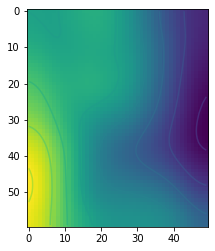

In [6]:
# performing rapid visual check of the DTM data
imshow(arr)
contour(arr)

now we generate a "fake" grid of pixel coordinates, to be fair we also consider that the 0,0 coordinate is actually at the upper left corner of the pixel and not the center, error is pretty low here, so we could just ignore it, but it easy to take it into account, just add half sampling step to the x and y arrays below:


In [7]:
from smalllib import raster_to_pyvista_mesh

Now we use the transform to determine the geographic coordinates for those pixels

In [8]:
T = np.array(T).reshape(3, 3)

asmesh = raster_to_pyvista_mesh(arr, T)

asmesh.points -= center_coords # recenter the mesh

# add the mesh to the 3D view
bp.add_mesh(asmesh)
asmesh.save("dtm.vtp")

# Path of the rover

In [9]:
# now the path
import geopandas as gpd
path = gpd.read_file("path.gpkg", driver="GPKG") # read already prepared data

In [10]:
from shapely.geometry import LineString
from smalllib import resample_linestring

ls = LineString(path.geometry) # from the list of points we create a linestring
sample = 0.1

resample_linestring(ls, sample)

points = resample_linestring(ls) # resmaple the line string with the method above

In [11]:
newpoints = np.array([np.array(p.coords)[0] for p in points]) # extract the poits as a numpy array

In [12]:
elev = sampleRasterAtPoints(dset, newpoints) # sample the elevation along the path
path_up = np.column_stack([newpoints, elev]) - center_coords # assign elevations and remove center of local ref. system

In [13]:
from smalllib import polyline_from_points

In [14]:
asline = polyline_from_points(path_up) # create a pyvista polydata from a set of points
tube = asline.tube(radius=0.1, scalars=None) # generate a tube for visualization
bp.add_mesh(tube, color="blue") #  add to 3D view
asline.save("path.vtp")

# The Horizons, very similar to the path

In [15]:
hf = "horizons.gpkg" # this geopackag contains the horizons as 2.5D layers, one for each horizon, they are named 0,1, and 2

vtp_hor = []
for i in np.arange(3):
    h = gpd.read_file(hf, layer=str(i)) # read the horizon
    hp = np.array([np.array(p.coords)[0] for p in h.geometry]) # to numpy array
    hp -= center_coords # local ref frame
    asline = polyline_from_points(hp) #  generate the polydata
    tube = asline.tube(radius=0.1, scalars=None) # and then the tube
    vtp_hor.append(asline)
    bp.add_mesh(tube, color="red") # add to theviewer
    asline.save(f"horizon_{str(i)}.vtp")

# The radargram
we also want to visualize the original radargram in 3d. to do so we need to define the geometry on which to show the radargram itself.
This is done by generating a mesh + UV coordinates for the corresponding texture

Radargram starts from station 3, and ends at station 16 so we need to shorten the overall path to that range


In [16]:
sstation = 3 # start station
estation = 16 # end station

In [17]:
idstart = path[path.progressive_number == sstation].index[0]
idend = path[path.progressive_number == estation].index[0] + 1 # +1 or it will exlude station 16

In [18]:
subpath = path.iloc[idstart:idend]
subpath = subpath.reset_index()

<AxesSubplot:>

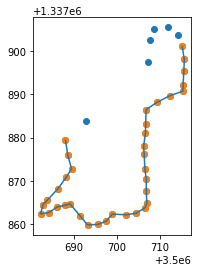

In [19]:
path.plot()
subpath.plot(ax=gca())

subline = LineString(subpath.geometry)
gpd.GeoDataFrame(geometry=[subline]).plot(ax=gca())

<AxesSubplot:>

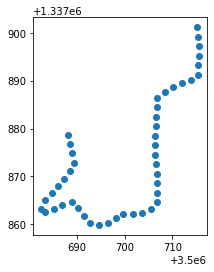

In [20]:
# resample the path line corresponding to the radargram
subline = resample_linestring(subline, 2)
gpd.GeoDataFrame(geometry=subline).plot()

In [21]:
max_depth = 13 #m the max depth we want to reach on the radargram, we are just good by having the full horizons

In [22]:
from smalllib import generate_plane_quads

first we compute elvations for the subline set of points

In [23]:
pts = np.array([np.array(p.coords)[0] for p in subline])
pts = np.column_stack([pts, sampleRasterAtPoints(dset, pts)]) - center_coords #  also center with respect of the local ref frame

pol, verts, cells =  generate_plane_quads(pts, max_depth) #  finally generate the mesh
bp.add_mesh(pol) # and display it

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x7f69af001760

# Texture
If we want to texturize the radargram with the original data, the process is a litle more complex. we need to compute suitable UV cordinates mapping the 3d geometry to the corrsponding image

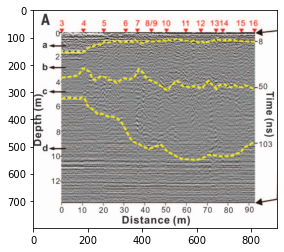

In [24]:
from PIL import Image
rgram_f = "images/radargram.png"
rad = Image.open(rgram_f) # load and inspect
imshow(rad)

In [25]:
# we define the portion of the radargram we are interested in... in meters
topleft = np.array([0,0, 1])
botright = np.array([92.5, -max_depth, 1]) # 92.5 is the maximum distance at station 16, you cann see it in notebook 2.

In [26]:
# to pass from meters to pixels we need to reload the radargram transform computed before
tr = np.loadtxt("radargram_transform.txt")

# but we actually need the inverse transform
from copy import deepcopy
tr_i = deepcopy(tr)

# inverting an augmented matrix not as simple as inverting a rotation matrix
tr_i[:2,:2] = np.linalg.inv(tr_i[:2,:2])
tr_i[:2,2] = -tr_i[:2,:2].dot(tr[:2, 2])

In [27]:
# we use the inverse transfrom to retrieve the corresponding pixel positions
topleft_px = np.abs(tr_i.dot(topleft))[:2].astype(int)
botright_px = np.abs(tr_i.dot(botright))[:2].astype(int)

Now we crop the original image to the portion of the radargram we really need, we could also avoid this, but it would make more complex to compute adequate UV coorinates

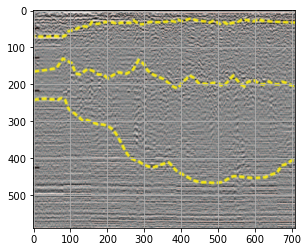

In [28]:
tx = rad.crop((*topleft_px, *botright_px))
imshow(tx)
grid() # this is our texture that will be entirely mapped onto the generated plane

In [29]:
upperv= verts[:len(pts)] #  this might not seem obvious, but upperv are the upper points of the segmted plane on which we want to project the radargram, enable commnted code above to see them
# aspt = pyvista.PolyData(upperv)
# bp.add_mesh(aspt) # these are the white points, the nodes of the path on the surfaces

In [30]:
from smalllib import generate_uv

In [31]:
from shapely.geometry import LineString, Point
asls = LineString(upperv)
uv = generate_uv(asls, upperv) # compute uv coordinates

In [32]:
# set the uv array in the polydata and get the image as a numpy array
pol.t_coords = uv
asarr = np.array(tx) # as an array

In [33]:
tx = Image.fromarray(asarr)
tx.save("texture.png")

text = pyvista.Texture(asarr)
text.InterpolateOn()
bp.add_mesh(pol, texture=text, ambient=0.8) # add to 3d

pol.save("radargram.vtp")

In [36]:
from smalllib import save_mesh_and_texture_as_obj
pol.points /= 1000
save_mesh_and_texture_as_obj("radargram.obj", pol, asarr)

pyvista_ndarray([[ 7.87167464e+00,  3.60267979e+00, -6.04736328e-01],
                 [ 8.19348286e+00,  1.62873970e+00, -5.99853516e-01],
                 [ 8.33820199e+00, -3.56413212e-01, -6.01562500e-01],
                 [ 8.26225294e+00, -2.35491330e+00, -6.09375000e-01],
                 [ 8.14607037e+00, -4.35153586e+00, -6.22314453e-01],
                 [ 8.05856555e+00, -6.34938707e+00, -6.39160156e-01],
                 [ 6.61629439e+00, -7.33434765e+00, -4.88281250e-01],
                 [ 4.74270974e+00, -8.02758070e+00, -3.36425781e-01],
                 [ 2.96503679e+00, -8.94402976e+00, -2.69042969e-01],
                 [ 1.24579552e+00, -9.95841129e+00, -1.29638672e-01],
                 [-4.04974398e-01, -1.10875520e+01, -3.90625000e-03],
                 [-5.08245389e-01, -1.30569674e+01, -5.54199219e-02],
                 [-5.60805129e-01, -1.50562658e+01, -1.19384766e-01],
                 [-6.85488950e-01, -1.70502535e+01, -1.93847656e-01],
                 [-9